In [11]:
import logging
import numpy as np
from docplex.mp.model_reader import ModelReader
import matplotlib.pyplot as plt
import numpy as np
from docplex.mp.basic import Expr
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution
from docplex.util.status import JobSolveStatus
import cplex.callbacks as cpx_cb
#from docplex.mp.callbacks.cb_mixin import ModelCallbackMixin
from docplex.mp.model import Model
from docplex.mp.relax_linear import LinearRelaxer



# Sample 1D ising model with constraints

In [12]:
from docplex.mp.model import Model
opt_model = Model(name="MIP Model")

Nc= 70
## Nc is the number of segments in which we cut the track time
Ny= 2*Nc
## Ny is the number of spin sites

num_flip = 1
### we have to check the constraint

Dist=500
## Distance to travel
delta_v=1
## Rate of acceleration/deceleration set to 1
#vmax= 89
## Max speed of a TGV in France (in m/s)
vmax=30
alpha=0.05
## Regenerative braking efficiency
### Simu b/a; dist; net-0; maxspeed
lambda1=0.1
lambda2=0.0000001
lambda3=0.8
lambda4=0.1

J_i_j = 1
h_i = 0.05

y={}
for i in range(0, Ny):
    y[i]= opt_model.binary_var(name=f"y_{i}")


"Note that: original variables y[t] are binary variables {0,1}, "
"To convert it into the spin variables {+1, -1}, we have to transform s[t] = (-1+(2*y[t]))"
" when y[t]= 0 then s[t] = -1 and when y[t]= 1 then s[t] = 1 "

objective = opt_model.linear_expr()
## objective is the hamiltonian/energy value we want to minimize

## Energy:
for i in range(Nc):
    #objective += (delta_v**2) * y[i*2+1] - alpha*(delta_v**2)*y[i*2]
    objective += (delta_v**2) * y[i*2+1]

## Constraint 1: (simultaneous braking/acceleration)
for i in range(Nc):
    objective += lambda1* y[i*2] * y[i*2 +1]

## Constraint 2: (Distance)
temp=0
for i in range(Nc):
    #speedy=0
    #for j in range(i+1):
    #    speedy += (y[i*2+1]-y[i*2])*delta_v
    temp += (((Nc-i)*delta_v*y[i*2+1]-(Nc-i)*delta_v*y[i*2])-Dist)
    #temp += speedy
objective += lambda2*((temp)**2)
    
## Constraint 3: (Net-Zero contraint)
temp=0
for i in range(Nc):
    temp += y[i*2]-y[i*2+1]
objective += lambda3 * ((temp)**2)

## Constraint 4: (Maximum Speed)
temp=0
for i in range(Nc):
    temp += delta_v*y[i*2 +1]
objective += lambda4 * ((temp-vmax)**2)

opt_model.minimize(objective)

## add constraint

#opt_model.add_constraint(opt_model.sum((-1+(2*y[r])) for r in range(0, Ny)) >= num_flip , "constraint") 

#### Print the optimization model

opt_model.print_information() 

print(opt_model.prettyprint())               



Model: MIP Model
 - number of variables: 140
   - binary=140, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
// This file has been generated by DOcplex
// model name is: MIP Model
// single vars section
dvar bool y_0;
dvar bool y_1;
dvar bool y_2;
dvar bool y_3;
dvar bool y_4;
dvar bool y_5;
dvar bool y_6;
dvar bool y_7;
dvar bool y_8;
dvar bool y_9;
dvar bool y_10;
dvar bool y_11;
dvar bool y_12;
dvar bool y_13;
dvar bool y_14;
dvar bool y_15;
dvar bool y_16;
dvar bool y_17;
dvar bool y_18;
dvar bool y_19;
dvar bool y_20;
dvar bool y_21;
dvar bool y_22;
dvar bool y_23;
dvar bool y_24;
dvar bool y_25;
dvar bool y_26;
dvar bool y_27;
dvar bool y_28;
dvar bool y_29;
dvar bool y_30;
dvar bool y_31;
dvar bool y_32;
dvar bool y_33;
dvar bool y_34;
dvar bool y_35;
dvar bool y_36;
dvar bool y_37;
dvar bool y_38;
dvar bool y_39;
dvar bool y_40;
dvar bool y_41;
dvar bool y_42;
dvar bool y_43;
dv

In [13]:
result = opt_model.solve(log_output=True) #(log_output=self.solver_config.cplex_log)
y_value=[]
for l in range(0, Ny):
    y_value.append(result.get_value(f"y_{l}"))
    #print(f"y_{l} =" , result.get_value(f"y_{l}")  )
    

print("Binary Variables" , y_value, "Objective value", result.objective_value )


Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 212.500000 after 0.00 sec. (0.08 ticks)
Tried aggregator 1 time.
MIP Presolve added 19460 rows and 9730 columns.
Reduced MIP has 19460 rows, 9870 columns, and 38920 nonzeros.
Reduced MIP has 9870 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.63 ticks)
Probing time = 0.00 sec. (5.30 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 4830 rows and 0 columns.
Reduced MIP has 14630 rows, 9870 columns, and 34090 nonzeros.
Reduced MIP has 9870 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (52.61 ticks)
Classifier predicts products in MIQP should not be linearized.
Represolve...

Tried aggregator 1 time.
Repairing indefinite Q in the objective.
Reduced MIQP has 0 rows, 140 columns, and 0 nonzeros.
Reduced MIQP has 140 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP 

## Visualising results:

In [14]:
import plotly.graph_objs as go
import plotly.offline as pyo
import numpy as np



def v(vini, a,b, delta_v):
    if a == 0 and b == 0:
        return vini
    elif a == 0 and b == 1:
        return vini + delta_v
    elif a == 1 and b == 0:
        return vini - delta_v
    else:
        return vini

def distance(speedi,speedi1):
    dstce=speedi + (speedi1-speedi)/2
    return dstce

def plot_speed(y, delta_v):
    N = len(y)
    speed = [0]

    for i in range(N // 2):
        speed.append(v(speed[i - 1], y[2 * i],y[2*i+1], delta_v))

    ditce=[0]
    for i in range(N//2-1):
        ditce.append(ditce[i]+distance(speed[i],speed[i+1]))
    plt.plot(ditce)
    N=N//2
    # Create the speed trace (first graph)
    trace_speed = go.Scatter(
        x=np.arange(0, N),
        y=speed,
        mode="lines",
        name="Speed vs Time",
        line=dict(color="royalblue", width=2),
        marker=dict(size=8, symbol="circle", line=dict(width=2, color="darkblue")),
    )

    # Create the layout for the speed graph
    layout_speed = go.Layout(
        title="Speed vs Time",
        titlefont=dict(size=24, family="Arial, sans-serif"),
        xaxis=dict(
            title="Time (s)",
            titlefont=dict(size=18, family="Arial, sans-serif"),
            showgrid=True,
            gridcolor="lightgray",
            zeroline=True,
            zerolinecolor="gray",
            tickfont=dict(size=14),
        ),
        yaxis=dict(
            title="Speed (m/s)",
            titlefont=dict(size=18, family="Arial, sans-serif"),
            showgrid=True,
            gridcolor="lightgray",
            zeroline=True,
            zerolinecolor="gray",
            tickfont=dict(size=14),
        ),
        plot_bgcolor="white",
        paper_bgcolor="rgba(255, 255, 255, 0.9)",
        showlegend=True,
    )

    # Create the figure for speed
    fig_speed = go.Figure(data=[trace_speed], layout=layout_speed)

    # Plot the speed graph
    pyo.plot(fig_speed, filename="speed_vs_time_no_constraints.html")


    

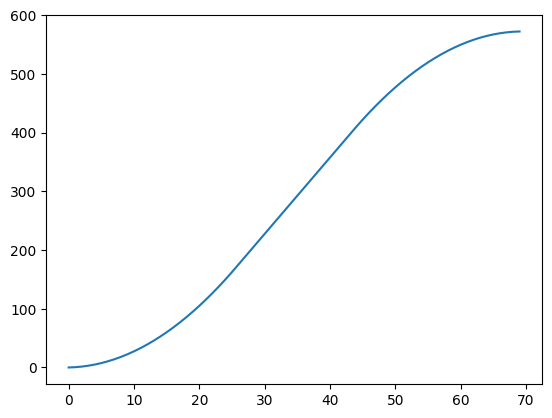

In [15]:
plot_speed(y_value,delta_v)